# **Financial Machine Learning Assignment**

Student: B241413

Project choice: Forecasting Stock Volatility - Is stock volatility past-dependent?

Stock Choices:
1. Salesforce (CRM)
2. Goldman Sachs (GS)

In [2]:
#Import necessary libraries for analysis
import os
from os import listdir
import random
import tqdm
import numpy as np
import pandas as pd
import time

import tensorflow as tf
from tensorflow.python import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K

from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential
from scipy import stats

from pprint import pprint
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import *
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from scipy import stats
import scipy.cluster.hierarchy as sch

%matplotlib inline

# These options determine the way floating point numbers are displayed.
np.set_printoptions(precision=4, suppress=True)

tf.random.set_seed(100)

2024-02-20 17:15:40.549495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/lg/tx14h9yd0y124jv8gq38m0mw0000gn/T/ipykernel_10462/3162438777.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Download stock from Yahoo Finance

In [3]:
### install and import yahoo finance
!pip install -U yfinance
import yfinance as yf

/Users/benblackwell/anaconda3/lib/python3.11/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
#### Define the stock Start and End Date ####
## you can define a longer time for your own use ##

start = pd.to_datetime('20000101',format='%Y%m%d')
end = pd.to_datetime('20231231',format='%Y%m%d')
days = (end-start).days
print('total days: ', days)

total days:  8765


In [5]:
#Reading the company listed stocks from the file 
# nasdaq_listed.csv contains all company tickers listed in nasdaq
df = pd.read_csv('/Users/benblackwell/Financial-Machine-Learning/nyse-listed.csv')
'''
find all company names listed on NASDAQ and download
the stoke prices from yahoo finance
'''
df.head()
Symbols = df['ACT Symbol'].tolist()

print('total number of tickers: ', len(Symbols))
print('first 10: ', Symbols[:10])



total number of tickers:  3298
first 10:  ['A', 'AA', 'AA$B', 'AAC', 'AAN', 'AAP', 'AAT', 'AAV', 'AB', 'ABB']


In [66]:
import pandas as pd
import yfinance as yf
import time

t0 = time.time()

# Define the stock tickers to retrieve prices for
tickers_to_download = ["GS", "CRM"]

# Define the time period for which you want to retrieve the prices
start = '2020-12-01'
end = '2024-01-01'

# Create empty dataframe
stock_final = pd.DataFrame()

# Empty list for the tickers that are not listed anymore
delisted_stock = []

# Iterate over each symbol
for ticker in tickers_to_download:
    print(f"Downloading data for {ticker}...", end=", ", flush=True)
    try:
        stock = yf.download(ticker, start=start, end=end, progress=False)
        if len(stock) == 0:
            delisted_stock.append(ticker)
        else:
            stock['Name'] = ticker
            stock_final = stock_final.append(stock, sort=False)
    except Exception:
        delisted_stock.append(ticker)

# Calculate total time taken
total_time = (time.time() - t0) / 60

print('\nTotal time:', total_time, 'minutes')
print('Total number of downloaded stocks:', len(stock_final['Name'].unique()))


/var/folders/lg/tx14h9yd0y124jv8gq38m0mw0000gn/T/ipykernel_10462/1943314609.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_final = stock_final.append(stock, sort=False)



Total time: 0.013015214602152507 minutes
Total number of downloaded stocks: 2


/var/folders/lg/tx14h9yd0y124jv8gq38m0mw0000gn/T/ipykernel_10462/1943314609.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_final = stock_final.append(stock, sort=False)


In [67]:
# Date index contains both date and time, we like to remove time information and use date information only

# # make index as a normal column
# stock_final.reset_index( inplace=True )

# # remove time, leave dates only
# stock_final['Date'] = pd.to_datetime(stock_final['Date'], format='%Y-%m-%d').dt.date

# # set index as the date
# stock_final.set_index('Date', inplace=True)

# make index as a normal column
stock_final.reset_index(inplace=True)

# remove time, leave dates only
stock_final['Date'] = pd.to_datetime(stock_final['Date'])

# Set 'Date' as the index
stock_final.set_index('Date', inplace=True)


stock_final.head(10)


,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-12-01,231.960007,234.869995,231.350006,232.080002,215.387085,2577600,GS
2020-12-02,232.080002,238.130005,231.580002,237.649994,220.556458,2136300,GS
2020-12-03,237.289993,238.850006,234.639999,235.470001,218.533234,2142600,GS
2020-12-04,237.699997,239.750000,236.949997,239.580002,222.347610,2373000,GS
2020-12-07,238.539993,239.850006,235.449997,238.449997,221.298904,1788600,GS
2020-12-08,237.009995,239.190002,236.580002,238.839996,221.660828,1371800,GS
2020-12-09,240.000000,245.360001,239.529999,242.820007,225.354568,3552300,GS
2020-12-10,240.000000,245.179993,239.509995,244.399994,226.820908,2541700,GS
2020-12-11,240.809998,241.199997,237.100006,239.990005,222.728134,2077300,GS


In [61]:
# !! if you have saved the data to your local place, no need to run this cell again !!
#*****************************************************************************************************************
print('total stock downloaded: ', stock_final['Name'].nunique())

# save to Google Drive, you should change the directory to your own
stock_final.to_csv('/Users/benblackwell/Financial-Machine-Learning/nyse_downloaded_stocks.csv')

total stock downloaded:  2


# Data Preparation 
As part of this project I have to calculate the volatility as the standard deviation of the 𝑁 daily arithmetic returns, but it's essential to note that this volatility should be computed based on returns within distinct, non-overlapping 𝑁-day intervals. 𝑁 can be five or ten days.

### Calculating Daily Returns

In [68]:

# Split the DataFrame into two based on the 'Name' column
gs_df = stock_final[stock_final['Name'] == 'GS']
crm_df = stock_final[stock_final['Name'] == 'CRM']

# Rename the 'Close' column for each
gs_df = gs_df.rename(columns={'Adj Close': 'GS_adj_close'}).drop(columns=['Name','Open','High', 'Low', 'Close', 'Volume'])
crm_df = crm_df.rename(columns={'Adj Close': 'CRM_adj_close'}).drop(columns=['Name','Open','High', 'Low', 'Close', 'Volume'])

gs_df.head(10)
crm_df.head(10)

,CRM_adj_close
Date,
2020-12-01,241.350006
2020-12-02,220.779999
2020-12-03,220.970001
2020-12-04,225.860001
2020-12-07,227.699997
2020-12-08,227.860001
2020-12-09,220.570007
2020-12-10,222.919998
2020-12-11,222.419998


In [73]:
# Calculate the simple return and the log return
# reference - Python for Finance

# For GS
gs_df['GS_simple_rtn'] = gs_df.GS_adj_close.pct_change()
gs_df['GS_log_rtn'] = np.log(gs_df.GS_adj_close/gs_df.GS_adj_close.shift(1))

# For CRM
crm_df['CRM_simple_rtn'] = crm_df.CRM_adj_close.pct_change()
crm_df['CRM_log_rtn'] = np.log(crm_df.CRM_adj_close/crm_df.CRM_adj_close.shift(1))
gs_df.head(10)

,GS_adj_close,GS_simple_rtn,GS_log_rtn,GS_realized_vol,GS_annualized_vol
Date,,,,,
2020-12-01,215.387085,NaN,NaN,NaN,NaN
2020-12-02,220.556458,0.024000,0.023717,NaN,NaN
2020-12-03,218.533234,-0.009173,-0.009216,NaN,NaN
2020-12-04,222.347610,0.017454,0.017304,NaN,NaN
2020-12-07,221.298904,-0.004717,-0.004728,NaN,NaN
2020-12-08,221.660828,0.001635,0.001634,NaN,NaN
2020-12-09,225.354568,0.016664,0.016527,NaN,NaN
2020-12-10,226.820908,0.006507,0.006486,NaN,NaN
2020-12-11,222.728134,-0.018044,-0.018209,NaN,NaN


I have calculated the simple and the log returns in order to utilise either one later on in the analysis. 

There are two types of returns:
- Simple returns: They aggregate over assets; the simple return of a portfolio is the weighted sum of the returns of the individual assets in the portfolio.

- Log returns: They aggregate over time; it is easier to understand with the help of an example—the log return for a given month is the sum of the log returns of the days within that month. 


The difference between simple and log returns for daily/intraday data will be very small,
however, the general rule is that log returns are smaller in value than simple returns.

# Calculating Volatilities
## Approach 1
Calculating the realized volatility on a monthly basis. This involves grouping the data by month and then applying a function to calculate the volatility for each month.
It uses the sum of squared log returns to calculate the volatility.
It annualizes the volatility by multiplying by the square root of 12 (since there are 12 months in a year).

### Goldman Sachs

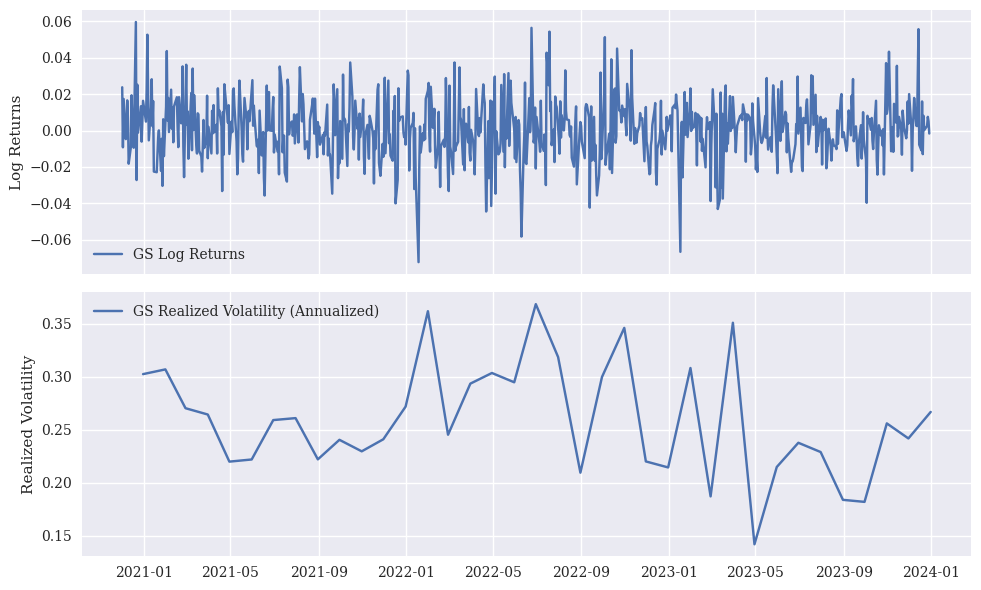

In [74]:
# Python for Finance Approach
# Define the function for calculating realized volatility
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

# Calculate the realized volatility for 'GS_log_rtn'
gs_df_rv = gs_df.groupby(pd.Grouper(freq='M'))['GS_log_rtn'].apply(realized_volatility).to_frame(name='rv')

# Annualize the realized volatility
gs_df_rv['rv'] = gs_df_rv['rv'] * np.sqrt(12)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(gs_df['GS_log_rtn'], label='GS Log Returns')  
ax[1].plot(gs_df_rv['rv'], label='GS Realized Volatility (Annualized)')

# Set the labels and legends
ax[0].set_ylabel('Log Returns')
ax[1].set_ylabel('Realized Volatility')
ax[0].legend()
ax[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

### Salesforce

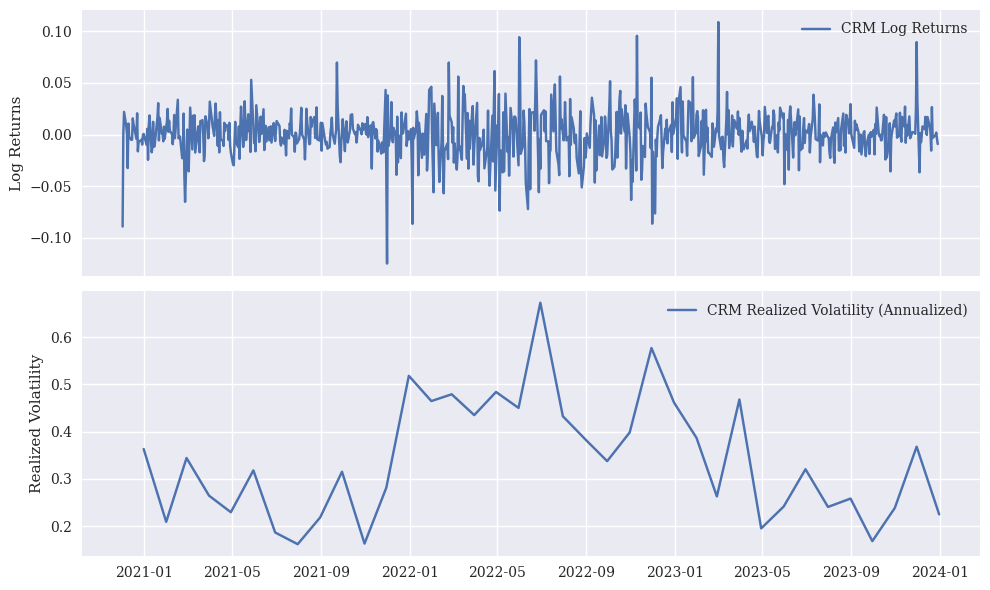

In [76]:
# Python for Finance Approach
# Define the function for calculating realized volatility
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

# Calculate the realized volatility for 'CRM_log_rtn'
crm_df_rv = crm_df.groupby(pd.Grouper(freq='M'))['CRM_log_rtn'].apply(realized_volatility).to_frame(name='rv')

# Annualize the realized volatility
crm_df_rv['rv'] = crm_df_rv['rv'] * np.sqrt(12)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(crm_df['CRM_log_rtn'], label='CRM Log Returns')  
ax[1].plot(crm_df_rv['rv'], label='CRM Realized Volatility (Annualized)')

# Set the labels and legends
ax[0].set_ylabel('Log Returns')
ax[1].set_ylabel('Realized Volatility')
ax[0].legend()
ax[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

## Approach 2
Calculating the rolling volatility using a specified window (e.g., 30 days) and then annualizing the result by multiplying by the square root of the number of trading days in a year (usually 252 for daily data).
It directly uses the standard deviation of the returns for the rolling window.

### Goldman Sachs

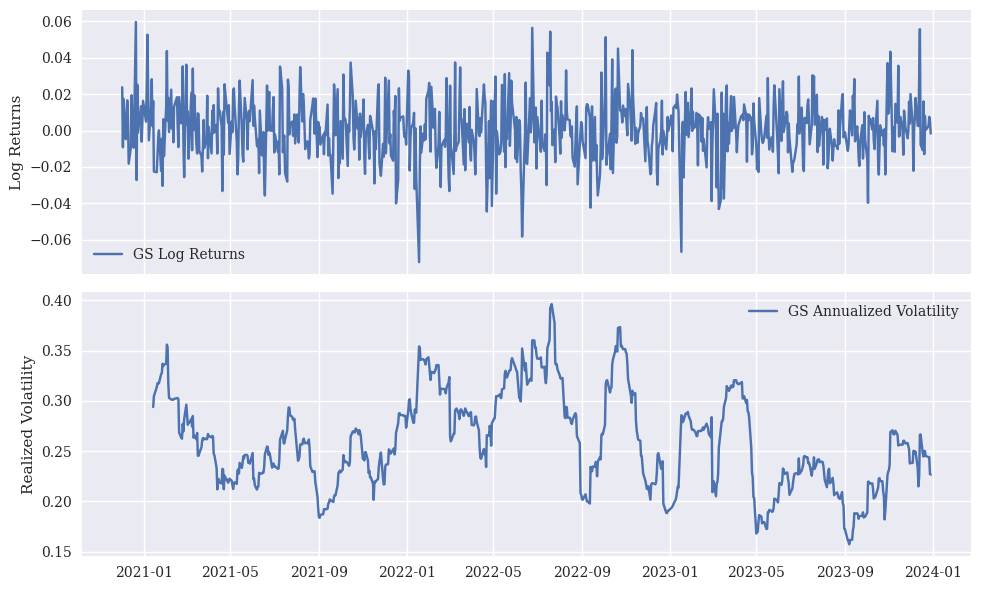

In [82]:
# Calculate the 30-day rolling volatility (standard deviation of log returns)
gs_df['GS_30Day_Rolling_Vol'] = gs_df['GS_log_rtn'].rolling(window=30).std()

# Annualize the volatility by multiplying by the square root of the number of trading days in a year
gs_df['GS_Annualized_Vol'] = gs_df['GS_30Day_Rolling_Vol'] * np.sqrt(252)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(gs_df['GS_log_rtn'], label='GS Log Returns')  
ax[1].plot(gs_df['GS_Annualized_Vol'], label='GS Annualized Volatility')
# Set the labels and legends
ax[0].set_ylabel('Log Returns')
ax[1].set_ylabel('Realized Volatility')
ax[0].legend()
ax[1].legend()
# Show the plot
plt.tight_layout()
plt.show()

### Salesforce

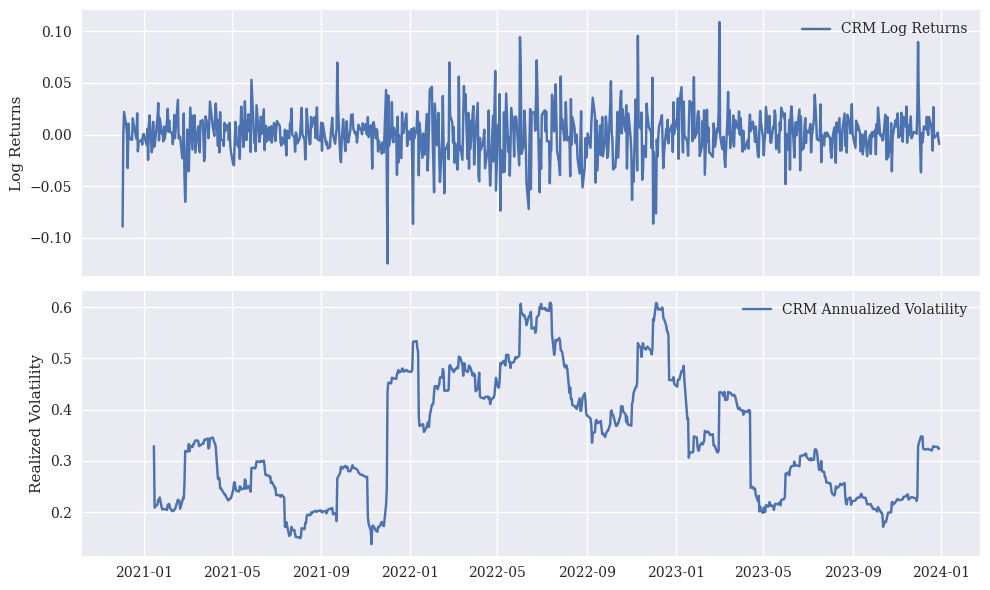

In [83]:
# Calculate the 30-day rolling volatility (standard deviation of log returns)
crm_df['CRM_30Day_Rolling_Vol'] = crm_df['CRM_log_rtn'].rolling(window=30).std()

# Annualize the volatility by multiplying by the square root of the number of trading days in a year
crm_df['CRM_Annualized_Vol'] = crm_df['CRM_30Day_Rolling_Vol'] * np.sqrt(252)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(crm_df['CRM_log_rtn'], label='CRM Log Returns')  
ax[1].plot(crm_df['CRM_Annualized_Vol'], label='CRM Annualized Volatility')
# Set the labels and legends
ax[0].set_ylabel('Log Returns')
ax[1].set_ylabel('Realized Volatility')
ax[0].legend()
ax[1].legend()
# Show the plot
plt.tight_layout()
plt.show()